<a href="https://colab.research.google.com/github/fatemafaria142/Bangla-News-Article-Abstractive-Summarization-using-Pretrained-Transformer-Models/blob/main/Bangla_News_Article_Summarization_using_mT5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.util import ngrams

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00


# **Loading datastet from huggingface**
* Dataset link: https://huggingface.co/datasets/csebuetnlp/xlsum

In [4]:
from datasets import load_dataset
dataset = load_dataset("csebuetnlp/xlsum",'bengali')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8102 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1012 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1012 [00:00<?, ? examples/s]

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 8102
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 1012
    })
    validation: Dataset({
        features: ['id', 'url', 'title', 'summary', 'text'],
        num_rows: 1012
    })
})


In [6]:
data = pd.DataFrame({
    'text': dataset['train']['text'],
    'summary':dataset['train']['summary']
})

In [7]:
data.head()

,text,summary
0,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...
1,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...
2,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...
3,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...
4,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...


# **Data Preprocessing**

In [8]:
def preprocess_bangla_text(text):
    # Remove website links
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove email links
    text = re.sub(r'\S+@\S+', '', text)

    # Remove specified punctuation
    punctuation = r'!#$%&\()*+-./:;?@[\]^_`{|}~'
    text = re.sub('[' + re.escape(punctuation) + ']', '', text)

    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Apply preprocessing to 'text' and 'summary' columns
data['text_preprocessed'] = data['text'].apply(preprocess_bangla_text)
data['summary_preprocessed'] = data['summary'].apply(preprocess_bangla_text)

In [9]:
data.head()

,text,summary,text_preprocessed,summary_preprocessed
0,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...
1,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...
2,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...
3,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...
4,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...


In [10]:
data = data.drop(['text','summary'],axis=1)

# Rename columns 'text_preprocessed' and 'summary_preprocessed' to 'text' and 'summary'
data = data.rename(columns={'text_preprocessed': 'text', 'summary_preprocessed': 'summary'})

# Display the DataFrame after renaming columns
data.head()


,text,summary
0,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...
1,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...
2,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...
3,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...
4,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...


**From main train dataset, I've taken 3000 samples for train, 500 samples for test, and 500 samples for validation**

In [11]:
train = data[:3000]
test = data[3000:3500]
validation = data[3500:4000]

train.to_csv('/content/drive/MyDrive/summary_train.csv',index=False)
test.to_csv('/content/drive/MyDrive/summary_test.csv',index=False)
validation.to_csv('/content/drive/MyDrive/summary_validation.csv',index=False)

# **Loading Train Dataset**


In [12]:
df_train = pd.read_csv('/content/drive/MyDrive/summary_train.csv')
df_train.head()

,text,summary
0,দুর্গাপুজায় মহিষাসুর বধ্যে মধ্য দিয়ে অশুভর ও...,হিন্দু বাঙালীরা যে সময়ে তাদের সবথেকে বড় উৎসব...
1,গত ২০ বছরে তিনি রাশিয়ার প্রেসিডেন্ট এবং প্রধা...,ভ্লাদিমির পুতিন তাঁর ক্ষমতায় থাকার ২০ বছর পূর...
2,বরিশাল সদরে চলছে নির্বাচনী প্রচার প্রচারণা। যদ...,বাংলাদেশের দক্ষিণাঞ্চলীয় জেলা বরিশাল এখন তুমু...
3,রবীন্দ্রনাথ ঠাকুর রবীন্দ্রনাথ ঠাকুর বাঙালির কা...,দু'হাজার চার সালে বিবিসি বাংলা একটি 'শ্রোতা জর...
4,আর কুমিল্লা থেকে বাস ভাড়া করে অনেকের সাথে নিজ...,'ভাষণ শুরু আগে মাথার উপর দিয়ে বিমান আর হেলিকপ...


# **Checking NaN values in Train dataset**

In [13]:
# Check for NaN values in df_train
nan_count = df_train.isna().sum()

# Display columns with NaN values and their respective counts
print("Columns with NaN values:")
print(nan_count[nan_count > 0])


Columns with NaN values:
Series([], dtype: int64)


# **Visualization of text and summaries Length of Training Dataset**

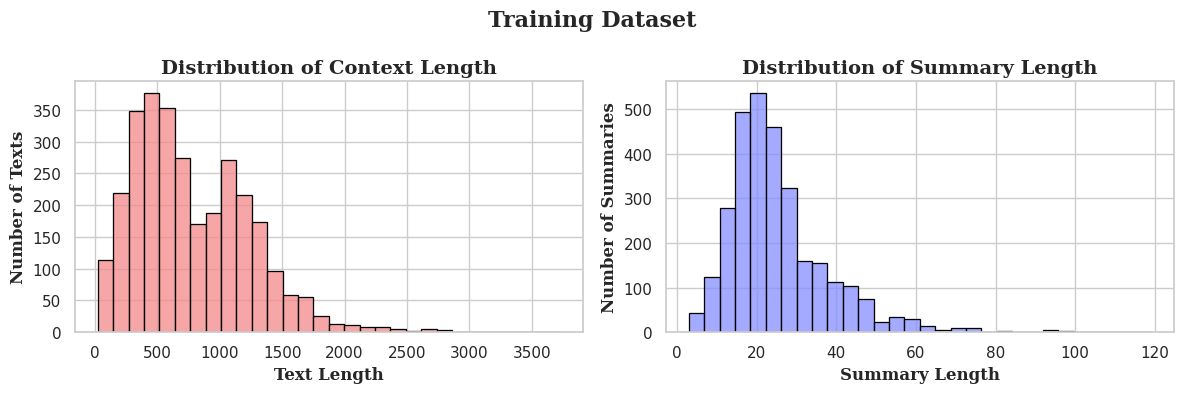

In [14]:
# Calculate the lengths of the columns
df_train['text_length'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_train['summary_length'] = df_train['summary'].apply(lambda x: len(str(x).split()))


# Set the aesthetic style and font settings
sns.set(style="whitegrid")
font_label = {'fontfamily': 'serif', 'fontsize': 12, 'fontweight': 'bold'}
font_title = {'fontfamily': 'serif', 'fontsize': 14, 'fontweight': 'bold'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 3 columns

# Plot 1: Distribution of Text Length
sns.histplot(data=df_train, x='text_length', bins=30, edgecolor='black', color='#f48989', ax=axes[0])
axes[0].set_title('Distribution of Context Length', fontdict=font_title)
axes[0].set_xlabel('Text Length', fontdict=font_label)
axes[0].set_ylabel('Number of Texts', fontdict=font_label)

# Plot 2: Distribution of Summary Length
sns.histplot(data=df_train, x='summary_length', bins=30, edgecolor='black', color='#848eff', ax=axes[1])
axes[1].set_title('Distribution of Summary Length', fontdict=font_title)
axes[1].set_xlabel('Summary Length', fontdict=font_label)
axes[1].set_ylabel('Number of Summaries', fontdict=font_label)


# Set a title for the set of subplots
plt.suptitle('Training Dataset', fontfamily='serif',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# **Count of unique words for text and summary in Train Dataset**

In [15]:
# Tokenize 'text' and 'summary' columns to count unique words
text_words = ' '.join(df_train['text']).split()
summary_words = ' '.join(df_train['summary']).split()

# Calculate unique words
unique_text_words = len(set(text_words))
unique_summary_words = len(set(summary_words))

# Display the count of unique words
print(f"Number of unique words in 'text': {unique_text_words}")
print(f"Number of unique words in 'summary': {unique_summary_words}")

Number of unique words in 'text': 141634
Number of unique words in 'summary': 16836


# **Loading Test Dataset**

In [16]:
df_test = pd.read_csv('/content/drive/MyDrive/summary_test.csv')
df_test.head()

,text,summary
0,প্যারিসের আইফেল টাওয়ার বন্ধ স্পেনে জরুরী কেনা...,করোনাভাইরাস প্রতিরোধে ইউরোপীয় ইউনিয়নের বৃহৎ ...
1,কুঁড়ে ঘরের মতো কাঠের ভেলা । ইন্দোনেশিয়ায় এই...,ইন্দোনেশিয়ার এক তরুণ গভীর সাগরে ভেসে ছিলেন টা...
2,২০১৫ সালের পরমাণু চুক্তি আর মানবেনা বলে জানিয়...,ইরান ঘোষণা করেছে যে তারা আর ২০১৫ সালের পরমাণু ...
3,বাঙ্গালী অধ্যুষিত পূর্ব লন্ডনের একটি সড়কে বাং...,ব্রিটিশ সাংস্কৃতিক সংগঠন 'সিটি লিট' বলেছে তাদে...
4,ডিমেনশিয়া এক ধরনের নিউরজিক্যাল রোগ যা মস্তিস্...,আলঝেইমার্স মস্তিস্কের এক ধরনের রোগ যার ফলে কিছ...


# **Checking NaN values in Test dataset**

In [17]:
# Check for NaN values in df_train
nan_count = df_test.isna().sum()

# Display columns with NaN values and their respective counts
print("Columns with NaN values:")
print(nan_count[nan_count > 0])


Columns with NaN values:
Series([], dtype: int64)


# **Visualization of Text and Summary Length of Testing Dataset**

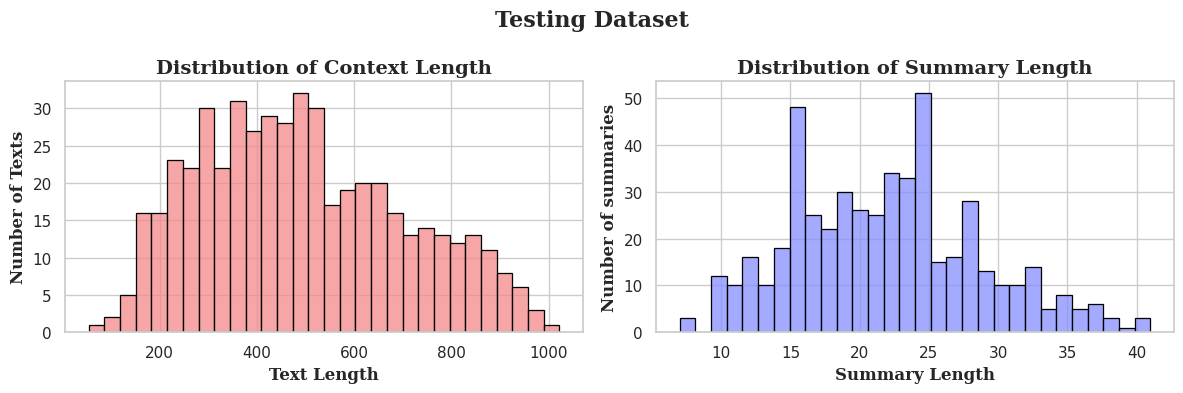

In [18]:
# Calculate the lengths of the columns
df_test['text_length'] = df_test['text'].apply(lambda x: len(str(x).split()))
df_test['summary_length'] = df_test['summary'].apply(lambda x: len(str(x).split()))


# Set the aesthetic style and font settings
sns.set(style="whitegrid")
font_label = {'fontfamily': 'serif', 'fontsize': 12, 'fontweight': 'bold'}
font_title = {'fontfamily': 'serif', 'fontsize': 14, 'fontweight': 'bold'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot 1: Distribution of Text Length
sns.histplot(data=df_test, x='text_length', bins=30, edgecolor='black', color='#f48989', ax=axes[0])
axes[0].set_title('Distribution of Context Length', fontdict=font_title)
axes[0].set_xlabel('Text Length', fontdict=font_label)
axes[0].set_ylabel('Number of Texts', fontdict=font_label)

# Plot 2: Distribution of Summary Length
sns.histplot(data=df_test, x='summary_length', bins=30, edgecolor='black', color='#848eff', ax=axes[1])
axes[1].set_title('Distribution of Summary Length', fontdict=font_title)
axes[1].set_xlabel('Summary Length', fontdict=font_label)
axes[1].set_ylabel('Number of summaries', fontdict=font_label)



# Set a title for the set of subplots
plt.suptitle('Testing Dataset', fontfamily='serif',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# **Count of unique words for text and summary in Test Dataset**

In [19]:
# Tokenize 'text' and 'passage' columns to count unique words
text_words = ' '.join(df_test['text']).split()
summary_words = ' '.join(df_test['summary']).split()

# Calculate unique words
unique_text_words = len(set(text_words))
unique_summary_words = len(set(summary_words))

# Display the count of unique words
print(f"Number of unique words in 'text': {unique_text_words}")
print(f"Number of unique words in 'summary': {unique_summary_words}")

Number of unique words in 'text': 34920
Number of unique words in 'summary': 4658


# **Validation dataset**

In [20]:
df_validation = pd.read_csv('/content/drive/MyDrive/summary_validation.csv')
df_validation.head()

,text,summary
0,ভাইস প্রেসিডেন্ট হিসাবে মিজ এবতেকারকে পুর্ননিয...,ইরানের প্রেসিডেন্ট হাসান রোহানি তার মন্ত্রিসভা...
1,প্রতিবেদনে বলা হচ্ছে যৌন নিপীড়নের শিকার শিশুদ...,অস্ট্রেলিয়ার চার্চগুলোর যাজকদের বিরুদ্ধে হাজা...
2,গ্যালারিতে অনেকেই এসেছিলেন বাঘের প্রতিকৃতি সেজ...,নিউজিল্যান্ডের বিপক্ষে বিশ্বকাপে নিজেদের ২য় ম...
3,"হাওয়ার্ড এক্স বলেছেন, উত্তর কোরিয়ানদের কোনো ...",শেষপর্যন্ত ভিয়েতনাম কর্তৃপক্ষ তাদের দেশ থেকে ...
4,সৌদি আরব থেকে ফিরে আসা নারী শ্রমিকদের অনেকেই ন...,সৌদি আরবে বাংলাদেশী নারী শ্রমিকদের ওপর নির্যাত...


# **Checking NaN values in validation dataset**

In [21]:
# Check for NaN values in df_train
nan_count = df_validation.isna().sum()

# Display columns with NaN values and their respective counts
print("Columns with NaN values:")
print(nan_count[nan_count > 0])


Columns with NaN values:
Series([], dtype: int64)


# **Visualization of Text and Summary Length of Validation Dataset**

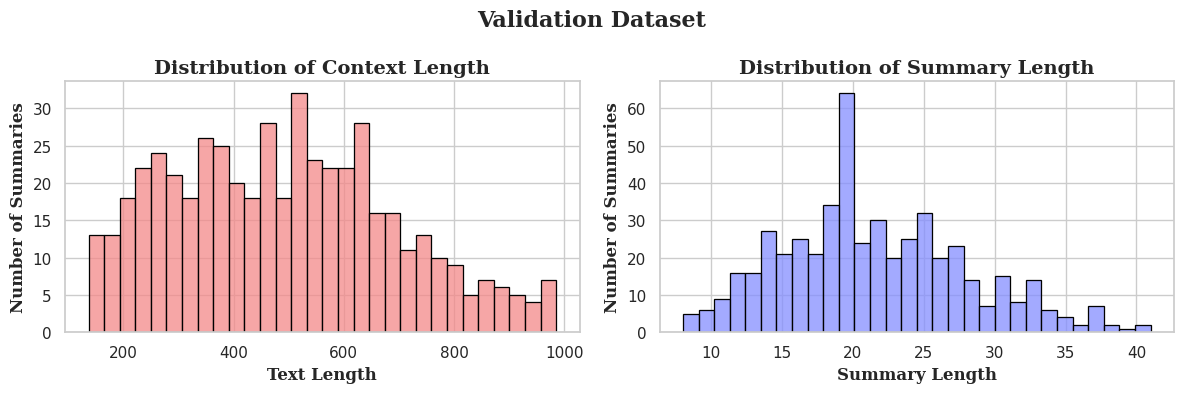

In [23]:
# Calculate the lengths of the columns
df_validation['text_length'] = df_validation['text'].apply(lambda x: len(str(x).split()))
df_validation['summary_length'] = df_validation['summary'].apply(lambda x: len(str(x).split()))


# Set the aesthetic style and font settings
sns.set(style="whitegrid")
font_label = {'fontfamily': 'serif', 'fontsize': 12, 'fontweight': 'bold'}
font_title = {'fontfamily': 'serif', 'fontsize': 14, 'fontweight': 'bold'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot 1: Distribution of Text Length
sns.histplot(data=df_validation, x='text_length', bins=30,edgecolor='black', color='#f48989', ax=axes[0])
axes[0].set_title('Distribution of Context Length', fontdict=font_title)
axes[0].set_xlabel('Text Length', fontdict=font_label)
axes[0].set_ylabel('Number of Summaries', fontdict=font_label)

# Plot 2: Distribution of Summary Length
sns.histplot(data=df_validation, x='summary_length', bins=30, edgecolor='black', color='#848eff', ax=axes[1])
axes[1].set_title('Distribution of Summary Length', fontdict=font_title)
axes[1].set_xlabel('Summary Length', fontdict=font_label)
axes[1].set_ylabel('Number of Summaries', fontdict=font_label)

# Set a title for the set of subplots
plt.suptitle('Validation Dataset', fontfamily='serif',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# **Count of unique words for text and summary in Validation Dataset**

In [ ]:
# Tokenize 'text' and 'passage' columns to count unique words
text_words = ' '.join(df_validation['text']).split()
summary_words = ' '.join(df_validation['summary']).split()

# Calculate unique words
unique_text_words = len(set(text_words))
unique_summary_words = len(set(summary_words))

# Display the count of unique words
print(f"Number of unique words in 'text': {unique_text_words}")
print(f"Number of unique words in 'summary': {unique_summary_words}")

# **Checking length of the datasets**

In [24]:
print("Train Dataset Length: ",len(df_train))
print("Test Dataset Length: ",len(df_test))
print("Validation Dataset Length: ",len(df_validation))

Train Dataset Length:  3000
Test Dataset Length:  500
Validation Dataset Length:  500


# **Installing Necesary Libraries**

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-7wwz739l
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-7wwz739l
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6857 sha256=20518314fbf0a8b05c541677409fc9146f9efbdbd9d57f9ec92bb838acd3f524
  Stored in directory: /tmp/pip-ephem-wheel-cache-bni_s3vd/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186457 sha256=6a551e51f981e5fc46d28b67762927ccbe87c88

In [ ]:
!pip install transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.8 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
!pip install torch

In [ ]:
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
!transformers-cli cache clear

2023-11-17 05:11:36.616316: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 05:11:36.616373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 05:11:36.616414: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 05:11:37.808358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: transformers-cli <command> [<args>]
Transformers CLI tool: error: argument {convert,download,env,run,serve,login,whoami,logout,repo,add-new-model,add-new-model-like,lfs-enable-largefiles,lfs-multipart-upload,pt-to-tf}: invalid choi

In [ ]:
!pip install transformers==4.10.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 15.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [ ]:
!pip install accelerate==0.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.24.1
    Uninstalling accelerate-0.24.1:
      Successfully uninstalled accelerate-0.24.1


In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install --upgrade transformers

# **Apply normalization to the datasets**

In [ ]:
from normalizer import normalize
# Apply normalization to the datasets
df_train['text'] = df_train['text'].apply(normalize)
df_train['summary'] = df_train['summary'].apply(normalize)

df_test['text'] = df_test['text'].apply(normalize)
df_test['summary'] = df_test['summary'].apply(normalize)

df_validation['text'] = df_validation['text'].apply(normalize)
df_validation['summary'] = df_validation['summary'].apply(normalize)

# **mT5 Model and Its Tokenizer**

In [ ]:
from transformers import MT5ForConditionalGeneration, AutoTokenizer
#https://huggingface.co/docs/transformers/model_doc/mt5
model_name = "google/mt5-small" # The variations it has -> mt5-small: 6, mt5-base: 12,mt5-large: 24, mt5-xl: 24, mt5-xxl: 24
model = MT5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

(…)oogle/mt5-small/resolve/main/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

(…)mall/resolve/main/generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

(…)small/resolve/main/tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

(…)ogle/mt5-small/resolve/main/spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

(…)all/resolve/main/special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


# **Custom dataset class**

In [ ]:
from torch.utils.data import Dataset, DataLoader

class BanglaSummaryDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=520):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        summary = self.data.iloc[idx]['summary']


        # Tokenize text
        inputs = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize summary
        tokenized_summary = self.tokenizer(
            summary,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Process tokenized answer labels
        labels = tokenized_summary['input_ids'].squeeze()
        attention_mask_labels = tokenized_summary['attention_mask'].squeeze()

        # Ignore padded tokens during training
        labels[attention_mask_labels == 0] = -100

        # Handle cases where the input sequence is longer than max_length
        if inputs['input_ids'].shape[1] > self.max_length:
            inputs['input_ids'] = inputs['input_ids'][:, :self.max_length]
            inputs['attention_mask'] = inputs['attention_mask'][:, :self.max_length]
            attention_mask_labels = attention_mask_labels[:self.max_length]

        # Ensuring labels and attention_mask_labels have the same length
        labels = labels[:self.max_length]

        # Using .squeeze() on labels
        labels = labels.squeeze()

        # Return as dictionaries
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': labels,

        }


# **Create datasets and data loaders**

In [ ]:
train_dataset = BanglaSummaryDataset(df_train, tokenizer)
validation_dataset = BanglaSummaryDataset(df_validation, tokenizer)
test_dataset = BanglaSummaryDataset(df_test, tokenizer)

train_dataloader = DataLoader(train_dataset , batch_size=10, shuffle=True)
validation_dataloader = DataLoader(validation_dataset , batch_size=10, shuffle=False)
test_dataloader = DataLoader(test_dataset , batch_size=10, shuffle=False)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

# **Train Dataset Encoding Printing: text, summary (input_ids,attention_mask)**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([ 42447,  14065,   3491,   2496,   6544,   2996,   5615,   2337,    259,
         20207,   1152,  41769,  65987,   3852,  15880,   3532,  16343,    994,
           378,   3179,   6969,    259,  26549,  14106,  22981,  27724,  66617,
          2207,    277,   1276,  52401, 107311,   1152,    378,   4381,  21643,
           259,  20207,   1152,  41769,  65987,   3852,  15880,   3532,  16343,
          3852,   7042,  10447,  92944,   4821,  80821,  13916,  22980,   2813,
          6223,   1276,  15880,    994,  14055,   6939,   4142,   2996, 156245,
          4151,   4381,  89706,    259,   9342,   4737,    259,   3019,  16402,
          8367,   1573,   2813,  21651,   8137,   1152,    378,  42447,  14065,
          3491,   2496,  27624,  12129,   2813,   6223,   1276,    259,  77867,
         10651,    259,  39491,   4529,  16867, 149877,  12856,   2212,   1573,
          5163,   2608,  70171,  55993,  23326,   1198,   3773,  21651,   8843,
           259,  20207,   115

# **Validation Dataset Encoding: text, summary (input_ids,attention_mask)**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in validation_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([   259,  30544,   4928,   2996, 172742,  10881,  57683,  34352,  43054,
           994,  19744,   3279,   1244, 167961,   9680, 212125,  56021,  33151,
         76636,  47660,    259,   5399,   8137,    259, 150215, 200161,  55819,
          7430,    259,  30544,   4928,   2996, 172742,  10881,  57683,    261,
          2996, 172742,  10881,  57683,   1198,  38021,  64270,  58103,   1152,
          9039,  42939,  26549,   6946,  74468,   3088,   2141,   1152,    378,
           259, 150215, 200161,  36876,  16752,  17315,   3491,   2496,    259,
         16612,   3873,   3154,  99254,  38137,   7042,  18497,  24855,  96893,
         89556,   4928,   7806,   4142,  34705,  47660,  95466,   4529,  18834,
          2592,   7430,   3215,  15372,    259,  36504,    259,    378,  18497,
         24855,  96893,  89556,   4928,   7806,   4142,   7982,  12898,   4689,
           259,  36504, 230560,   2608,  26117,    259,   1276,  22189,    378,
           259,  70996,    25

# **Test Dataset Encoding: text, summary (input_ids,attention_mask)**


In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([ 91491,   7588,  37074,  23568,  76477,   2369,    259,   3459,  19478,
           259,  37450,  70800,    994,   3424,   7725,  26492,  15372,    259,
         54692,  44408,   3459,    261,    259, 233458,  17475,   8145,  95581,
          4399,   6173, 111655,   3795,   3279,  58973,  12338,    259,  17710,
          7430,   1198,   6019,  14174,    259,  26857,   6053,    259,  38137,
          2326,  19478,   6333,   1276,   4381, 101186,  33899, 123878,   7589,
         14606,   8137,    378,    259,   1413,   3459, 227016,   7042,  22807,
         19685,  63866,    259,  10684,    994,  70800,    994,  23974,    259,
          8909,  19011,   7162,   2813,  44601,    259,  50939,   1276,   6019,
          4402,   3088,   6019,  13420,   3019,    378,  18497,  82010,    259,
        127424,   1198,    259,  61079,  36876,  25145,   4718,    378, 104156,
        173591,    994,   4529,   3148,  20694,   3019,  60236,  25145,   4718,
           378,   4230,  1523

# **Train Dataset Decoding: text and summary**
* converting the tensor values to human-readable tokens

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: যুগলরা যখন পরস্পর আবেগীয় কোন টান অনুভব করে না তখন আসলে তারা কী করতে পারে পরিচয় গোপন রাখতে এই প্রতিবেদনে উল্লেখিত সবার নাম বদলে দেয়া হয়েছে। সারা বিশ্বে যুগলরা শোয়ার ঘরে দূরত্ব তৈরি হওয়া নিয়ে কথা বলা এড়িয়ে চলে থাকে, যদিও ওই যুগল এবং বৃহত্তর পরিবারের ক্ষেত্রে এই অবস্থা বাস্তবিক পক্ষে তালাকের চেয়ে বেশি ক্ষতি করে। বিবিসি এ ধরণেরই কিছু যুগলের সাথে যারা "আবেগ শূন্যতা" অনুভব করছেন তাদের অভিজ্ঞতা নিয়ে কথা বলেছে এবং থেরাপিস্টদের সাথে এর সমাধানের বিষয়ে জানতে চেয়েছে। বৈবাহিক আবেগ শূন্যতা "সত্যি করে বলতে গেলে আমি আসলে বলতে পারবো না যে আমি বিবাহিত নাকি তালাক প্রাপ্ত," বলছিলেন কামাল এখানে তার আসল নাম দেয়া হয়নি। লন্ডনের টেলিযোগাযোগ বিষয়ক কনসালটেন্ট তার স্ত্রী থুরায়ার সাথে ২০ বছর ধরে সংসার করছেন এবং তাদের দুটি ছেলে রয়েছে যাদের বয়সও ২০ বছরের কাছাকাছি। আরো পড়তে পারেন বিয়ের পর কেমন হয় নববধূর অভিজ্ঞতা 'ক্যান্সার হবার পর থেকে সংসার বলতে কিছুই নাই' সন্তান জন্মের পর মানসিক সমস্যায় ভোগেন পুরুষরাও অনেক যুগল বলেন যে, তাদের মধ্যে কোন ধরণের আবেগ কাজ করে না ৪৬ বছর বয়সী কা

# **Validation Dataset Decoding: text and summary**
* converting the tensor values to human-readable tokens

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in validation_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: ভাইস প্রেসিডেন্ট হিসাবে মিজ এবতেকারকে পুর্ননিয়োগ করা হয়েছে ইরানে ১২জন ভাইস প্রেসিডেন্ট, প্রেসিডেন্টের ক্ষমতাধীন সংস্থাগুলো পরিচালনা করেন। ইরানে ১৯৭৯ সালে ইসলামী বিপ্লবের পর দেশটির মন্ত্রিসভায় নিয়োগ পান মাত্র একজন নারী সদস্য । দেশটির মন্ত্রিসভায় সুন্নি সদস্যেরও অভাব রয়েছে। শিয়া সংখ্যাগরিষ্ঠ ইরানে সুন্নিরা সংখ্যায় শতকরা ১০ ভাগ। মন্ত্রিসভাকে অনুমোদন দেয় সংসদ। মাসুমে এবতেকারকে ভাইস প্রেসিডেন্ট হিসাবে পরিবার ও নারী বিষয়ক মন্ত্রণালয়ের দায়িত্ব দেওয়া হয়েছে। লেইয়া জোনেয়দিকে আইন বিষয়ক ভাইস প্রেসিডেন্টের দায়িত্ব দেওয়া হয়েছে। নাগরিক অধিকার বিষয়ে প্রেসিডেন্টের সহকারীর দায়িত্ব পাওয়া শাহীনদক্ত মোলাভার্দি বলেছেন পুরো পুরুষ সদস্যের এই মন্ত্রিসভা এটাই বুঝিয়ে দেয় যে ''আসলেই কোন অগ্রগতি নেই।'' আরও পড়তে পারেন ৯১ বছর বয়সে স্নাতক ডিগ্রী অর্জন করলেন থাই 'নানী' ব্রিটেনে দক্ষিণ এশিয়ান নারীরা কেন ক্যান্সারের কথা গোপন করেন 'ব্রিজ খেলতে দেখলে পরিবার বলতো জুয়া খেলছি' সংস্কারবাদীরা বলছেন নতুন মন্ত্রিসভায় নারীদের অনুপস্থিতি দেখে মনে হচ্ছে মি রোহানি ইরানের ধর্মীয় প্রত

# **Test Dataset Decoding: text and summary**
* converting the tensor values to human-readable tokens

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_dataloader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['labels'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)


    # Break out of the loop after processing the first batch
    break


Decoded Input Text: প্যারিসের আইফেল টাওয়ার বন্ধ স্পেনে জরুরী কেনাকাটা, ঔষধ ক্রয় কিংবা কাজ ছাড়া মানুষজনের ঘরের বাইরে বের হওয়ার উপর নিষেধাজ্ঞা দেয়া হয়েছে। ইটালির পর ইউরোপের মধ্যে স্পেনেই সবচেয়ে বেশি মৃত্যুর ঘটনা ঘটেছে। দেশটিতে মৃতের সংখ্যা ১৯১ জন। ফ্রান্সে মারা গেছে ৯১ জন। সেখানে ক্যাফে, রেস্তোরাঁ, সিনেমা হল এবং বেশিরভাগ দোকানপাটই এখন বন্ধ। সবচেয়ে বেশি মৃত্যুর ঘটনা ঘটা ইতালিতে গত সোমবার থেকে লকডাউন চলছে। দেশটিতে মৃতের সংখ্যা ১৪৪০ জন। বিশ্ব স্বাস্থ্য সংস্থা বলছে, ইউরোপই এখন করোনাভাইরাস সংক্রমণের কেন্দ্রে রয়েছে। করোনাভাইরাস গাইড আপনার প্রশ্নের উত্তর করোনাভাইরাস থেকে নিজেকে যেভাবে নিরাপদ রাখবেন করোনাভাইরাস ঠেকাতে যে সাতটি বিষয় মনে রাখবেন যে পরীক্ষার মাধ্যমে শনাক্ত করা যাবে করোনাভাইরাস স্পেনে যে ব্যবস্থা নেয়া হয়েছে ৪ কোটি ৬৭ লাখ জনসংখ্যার দেশ স্পেনে ৬,৩০০ জন করোনাভাইরাস আক্রান্ত রয়েছে। প্রধানমন্ত্রী পেদ্রো স্যানচেজ এবং তার স্ত্রী বেগোনা গোমেজ শনিবার রাতে প্রধানমন্ত্রী পেদ্রো স্যানচেজের স্ত্রী বেগোনা গোমেজকে করোনাভাইরাস আক্রান্ত হিসেবে শনাক্ত করা হয়। শুক্রবার সন্ধ্যার পর থেকেই ১

# **Training Arguments**

In [ ]:
from transformers import TrainingArguments
from torch.optim import AdamW


# Create a custom optimizer using torch.optim.AdamW
custom_optimizer = AdamW(
    model.parameters(),
    lr=1e-3,  # Learning rate
    eps=1e-8,  # Epsilon value to prevent division by zero
    weight_decay=0.01,  # Weight decay (L2 regularization)
)

# Define the TrainingArguments for question answering
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary',
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,  # Accumulate gradients over 8 small batches
    evaluation_strategy="steps",
    eval_steps=500,
    save_total_limit=2,
    save_steps=500,
    learning_rate=1e-3,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    lr_scheduler_type="cosine_with_restarts",  # Setting the learning rate scheduler type
    warmup_steps=100,  # Number of warmup steps
    weight_decay=0.01,  # Weight decay (L2 regularization)
    logging_dir='/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary',  # Using the same directory for logs
    logging_steps=500,  # Log every 500 steps
)


# **Custom Data Collator for Summary Generation**
* A custom data collator for summary generation is used to handle the specific data formatting required for training models on question answering tasks. It facilitates the processing of input data into a format suitable for model training by performing tasks such as padding, truncation, and organizing inputs and labels for the Summary model.

In [ ]:
import torch
import torch.nn.functional as F
from transformers import DataCollatorForSeq2Seq

class CustomDataCollatorForSeq2Seq(DataCollatorForSeq2Seq):
    def __call__(self, features):
        batch = super().__call__(features)

        # Find the maximum length of labels in the batch
        max_label_length = max(feature["labels"].shape[-1] for feature in features)

        # Pad or truncate the "labels" arrays to have the same length
        batch["labels"] = torch.stack([
            F.pad(torch.as_tensor(feature["labels"]), (0, max_label_length - feature["labels"].shape[-1]), value=-100)
            for feature in features
        ])

        return batch




# Creating a data collator using the custom collator
data_collator = CustomDataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=520,
    label_pad_token_id=tokenizer.pad_token_id,
    pad_to_multiple_of=8  # Ensuring the sequence length is a multiple of 8 (adjust as needed)
)

# **Trainer**
* The trainer package provides utilities to write re-usable training scripts. The core idea is to use a trainer that implements a nested loop, where the outer loop runs the data collection steps and the inner loop the optimization steps.

In [ ]:
from transformers import Trainer
# Define the Trainer with the custom optimizer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    optimizers=(custom_optimizer, None),  # Passing the custom optimizer here
)


# **Training Starts Here**

In [ ]:
# Fine-tune the model
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=375, training_loss=1.8131240234375, metrics={'train_runtime': 800.812, 'train_samples_per_second': 3.746, 'train_steps_per_second': 0.468, 'total_flos': 1611034214400000.0, 'train_loss': 1.8131240234375, 'epoch': 1.0})

# **Saving model and tokenizer**

In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/Bangla_Summary_mT5_Model.pt')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/Bangla_Summary_mT5_Tokenizer.json')


('/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/Bangla_Summary_mT5_Tokenizer.json/tokenizer_config.json',
 '/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/Bangla_Summary_mT5_Tokenizer.json/special_tokens_map.json',
 '/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/Bangla_Summary_mT5_Tokenizer.json/spiece.model',
 '/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/Bangla_Summary_mT5_Tokenizer.json/added_tokens.json',
 '/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/Bangla_Summary_mT5_Tokenizer.json/tokenizer.json')

# **Loading trained model and tokenizer**

In [ ]:
from transformers import MT5ForConditionalGeneration, AutoTokenizer

# Load the saved model
model = MT5ForConditionalGeneration.from_pretrained('/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/Bangla_Summary_mT5_Model.pt')

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/Bangla_Summary_mT5_Tokenizer.json')


# **Evaluation Metrics Installing**

In [ ]:
!pip install evaluate

In [ ]:
!pip install sacrebleu

In [ ]:
!pip install rouge_score

In [ ]:
!pip install jiwer

# **Testing the model**

In [ ]:
decoded_predictions_batch = []
decoded_references_batch = []

# Loop through the test dataset and generate predictions
for batch in test_dataloader:
    inputs = batch['input_ids'].to('cuda')  # Move inputs to the 'cuda' device
    labels = batch['labels'].to('cuda')  # Move labels to the 'cuda' device

    # Ensuring the model, inputs, and labels are on the same device
    model = model.to(inputs.device)

    # Generating answers using our model
    with torch.no_grad():
        # Generating predictions
        predictions = model.generate(inputs, max_length=520, num_beams=4, early_stopping=True)

        # Decoding generated answers
        try:
            decoded_predictions_batch.extend(tokenizer.batch_decode(predictions.cpu(), skip_special_tokens=True))
        except Exception as e:
            print("Exception occurred during decoding (predictions):", e)


        # Decoding labels for references
        try:
            # Converting labels to a list of token IDs
            labels_list = labels.cpu()
             # Decoding each label sequence
            decoded_references_batch.extend([tokenizer.decode(ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True) for ids in labels_list])
        except Exception as e:
            print("Exception occurred during decoding (references):", e)



In [ ]:
print(decoded_predictions_batch)

['ইটালির পর ইউরোপের মধ্যে করোনাভাইরাস আক্রান্ত হিসেবে শনাক্ত করা হয়েছে।', 'গত ১৮ বছরের তরুণ আলদি নোভেল আদিলাং নামের একটি ভেলা দিয়ে মাছ ধরার ফাঁদ পাওয়া যাচ্ছে।', 'ইরানের পরমাণু চুক্তি আর মানবেনা বলে জানিয়েছে ইরান।', 'লন্ডনে ইংরেজি পর দ্বিতীয় সর্বোচ্চ ব্যবহৃত ভাষা ব্যবহারকারীর সংখ্যা বেড়েছে।', 'যুক্তরাজ্যে এক ধরনের স্মৃতিশক্তি লোপ পাওয়া এক ধরনের নিউরজিক্যাল রোগ যা মস্তিস্কের কর্মক্ষমতার ওপর প্রভাব ফেলছে।', 'আয়ারল্যান্ডের প্রথম নগ্ন বিচ উদ্বোধন হবে এপ্রিল মাসে।', 'ফেসবুক ও ইনস্টাগ্রামের ব্যবহার কমাতে আসছে নতুন টুল।', 'যুক্তরাজ্যের ঝালকাঠির মেয়ে শারমিন আক্তার ঝালকাঠির মেয়ে শারমিন আক্তার ঝালকাঠির মেয়ে শারমিন আক্তার ঝালকাঠির মেয়ে শারমিন আক্তার।', 'লেবানন বিস্ফোরণের মুহুর্ত রাশিয়ান মালিকানাধীন জাহাজ এমভি রোসাস জাহাজ বৈরুত বন্দরে পৌঁছেছে।', 'লন্ডনে ট্রেনে ব্যাপক মাত্রায় ওয়াইফাই এবং মোবাইল ফোন বিস্তারের ফলে কাজের দিনের সময়কে বাড়িয়ে দিয়েছে ইউনিভার্সিটি অব দ্যা ওয়েস্ট অব ইংল্যান্ড।', 'বাংলাদেশে ঢাকার মহাখালী থেকে বিমানবন্দরগামী সড়ক পরিবহন আইনে যাওয়ার ঘোষণা ছাড়াই বাস চলাচল ব

In [ ]:
print(len(decoded_predictions_batch))

500


In [ ]:
print( decoded_references_batch)

['করোনাভাইরাস প্রতিরোধে ইউরোপীয় ইউনিয়নের বৃহৎ দুই দেশ স্পেন ও ফ্রান্সও ইটালির পথ অনুসরণ করে জরুরি বিধিনিষেধ আরোপ করলো।', 'ইন্দোনেশিয়ার এক তরুণ গভীর সাগরে ভেসে ছিলেন টানা ৪৯দিন। এরপর তাঁকে জীবিত উদ্ধার করা হয়।', 'ইরান ঘোষণা করেছে যে তারা আর ২০১৫ সালের পরমাণু চুক্তির দ্বারা আরোপিত বিধিনিষেধ মানবেনা।', "ব্রিটিশ সাংস্কৃতিক সংগঠন 'সিটি লিট' বলেছে তাদের একটি সাম্প্রতিক গবেষণায় দেখা গিয়েছে লন্ডনে সবচেয়ে বেশি ব্যবহৃত ভাষার মধ্যে বাংলার অবস্থান দ্বিতীয়। এ নিয়ে বাংলাদেশের সামাজিক মাধ্যমে শোরগোল চলছে।", 'আলঝেইমার্স মস্তিস্কের এক ধরনের রোগ যার ফলে কিছু মনে রাখতে না পারে না রোগী অনেকসময় কয়েকবছর ধরে ধীরে ধীরে বেড়ে ওঠে। বিশেষজ্ঞরা বলেন, শুরুর দিকে অনেক সময়ই তা ধরা পড়ে না। কারণ এই রোগের লক্ষণ অন্যান্য অসুস্থতার ক্ষেত্রেও দেখা যেতে পারে।', 'দক্ষিণ ডাবলিনে আগামী এপ্রিল মাসে চালু হবে হাক ক্লিফ বিচ যাকে বলা হচ্ছে প্রথম ন্যুড বিচ বা নগ্ন সৈকত। এর ফলে আয়ারল্যান্ডে এমন একটি জায়গা তৈরি হচ্ছে যেখানে লোকজন গিয়ে নগ্ন হয়ে গোসল করতে পারবে ।', 'ফেসবুক এবং ইনস্টাগ্রাম একটি নতুন টুল প্রকাশ করেছে যা 

In [ ]:
print(len(decoded_references_batch))

500


# **Metrics Loading**

In [ ]:
from evaluate import load

# Loading the evaluation metric for Character Error Rate (CER) and Word Error Rate (WER) and Exact Match(em)
cer_metric = load("cer")
wer_metric = load("wer")
exact_match_metric = load("exact_match")

# Loading BLEU and METEOR metrics
bleu_metric = load("bleu")
meteor = load('meteor')

# Calculating Character Error Rate (CER), Word Error Rate (WER) and Exact Match (EM)
results_CER = cer_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)
results_WER = wer_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)
results_em = exact_match_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)

# Calculating Bilingual Evaluation Understudy (BLEU) , Recall-Oriented Understudy for Gisting Evaluation (ROUGE) and METEOR(M)
results_bleu = bleu_metric.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)
results_met = meteor.compute(predictions=decoded_predictions_batch, references=decoded_references_batch)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
print("Character Error Rate for Bangla Summary:", results_CER)
print("Word Error Rate for Bangla Summary:",results_WER)
print("Exact Match for Bangla Summary:",results_em)
print("BLEU Score for Bangla Summary:",results_bleu)
print("METEOR for Bangla Summary:",results_met)

Character Error Rate for Bangla Summary: 0.9097143779248024
Word Error Rate for Bangla Summary: 1.1001187539965287
Exact Match for Bangla Summary: {'exact_match': 0.0}
BLEU Score for Bangla Summary: {'bleu': 0.02606627408217862, 'precisions': [0.1440957381853706, 0.0512420340746521, 0.022951731812491306, 0.011810435042607266], 'brevity_penalty': 0.6930095895326431, 'length_ratio': 0.7316833452466047, 'translation_length': 8189, 'reference_length': 11192}
METEOR for Bangla Summary: {'meteor': 0.08962808328887112}


In [ ]:
!pip install rouge-score

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.4 MB/s eta 0:00:00


# **ROUGE Score Calculation**

In [ ]:
from rouge_score import rouge_scorer
from unidecode import unidecode

# Initialize the Rouge scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=False)

# Preprocess the text
def preprocess_text(text):
    text = unidecode(text)
    tokens = text.split()
    return ' '.join(tokens)

# Calculate scores for each pair of predictions and references
rouge1_f1_scores = []
rouge1_precision_scores = []
rouge1_recall_scores = []
rouge2_f1_scores = []
rouge2_precision_scores = []
rouge2_recall_scores = []
rougeL_f1_scores = []
rougeL_precision_scores = []
rougeL_recall_scores = []

for ref, pred in zip(decoded_references_batch, decoded_predictions_batch):
    candidate_summary = preprocess_text(pred)
    reference_summary = preprocess_text(' '.join(ref))
    scores = scorer.score(reference_summary, candidate_summary)

    rouge1_f1_scores.append(scores['rouge1'].fmeasure)
    rouge1_precision_scores.append(scores['rouge1'].precision)
    rouge1_recall_scores.append(scores['rouge1'].recall)
    rouge2_f1_scores.append(scores['rouge2'].fmeasure)
    rouge2_precision_scores.append(scores['rouge2'].precision)
    rouge2_recall_scores.append(scores['rouge2'].recall)
    rougeL_f1_scores.append(scores['rougeL'].fmeasure)
    rougeL_precision_scores.append(scores['rougeL'].precision)
    rougeL_recall_scores.append(scores['rougeL'].recall)

# Calculate the average scores
avg_rouge1_f1 = sum(rouge1_f1_scores) / len(rouge1_f1_scores)
avg_rouge1_precision = sum(rouge1_precision_scores) / len(rouge1_precision_scores)
avg_rouge1_recall = sum(rouge1_recall_scores) / len(rouge1_recall_scores)
avg_rouge2_f1 = sum(rouge2_f1_scores) / len(rouge2_f1_scores)
avg_rouge2_precision = sum(rouge2_precision_scores) / len(rouge2_precision_scores)
avg_rouge2_recall = sum(rouge2_recall_scores) / len(rouge2_recall_scores)
avg_rougeL_f1 = sum(rougeL_f1_scores) / len(rougeL_f1_scores)
avg_rougeL_precision = sum(rougeL_precision_scores) / len(rougeL_precision_scores)
avg_rougeL_recall = sum(rougeL_recall_scores) / len(rougeL_recall_scores)

# Print the average scores
print("Average Rouge-1 F1 Score:", avg_rouge1_f1)
print("Average Rouge-1 Precision:", avg_rouge1_precision)
print("Average Rouge-1 Recall:", avg_rouge1_recall)

print("Average Rouge-2 F1 Score:", avg_rouge2_f1)
print("Average Rouge-2 Precision:", avg_rouge2_precision)
print("Average Rouge-2 Recall:", avg_rouge2_recall)

print("Average Rouge-L F1 Score:", avg_rougeL_f1)
print("Average Rouge-L Precision:", avg_rougeL_precision)
print("Average Rouge-L Recall:", avg_rougeL_recall)


Average Rouge-1 F1 Score: 0.009542003866149985
Average Rouge-1 Precision: 0.03778293209056925
Average Rouge-1 Recall: 0.0059031233173090876
Average Rouge-2 F1 Score: 7.625344352617079e-05
Average Rouge-2 Precision: 0.00020098039215686275
Average Rouge-2 Recall: 4.72866284384609e-05
Average Rouge-L F1 Score: 0.009426937484000959
Average Rouge-L Precision: 0.03736807209975019
Average Rouge-L Recall: 0.00583533513534473


# **Saving results to a csv file**

In [ ]:
# Create a DataFrame to store translations
generated_summary_df = pd.DataFrame({
    'text': df_test['text'],  # Assuming 'test_data' contains our test dataset
    'Reference_Summary': decoded_references_batch,
    'Generated_Summary': decoded_predictions_batch
})

# Save translations to a CSV file
generated_summary_df.to_csv("/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/mT5_generated_answers.csv", index=False)


# **Word Information Lost Calculation**

In [ ]:
def calculate_word_information_lost(original_summary, generated_summary):
    # Tokenize the text into unique tokens
    original_tokens = set(original_summary.split())
    generated_tokens = set(generated_summary.split())

    # Calculate the number of unique tokens before and after processing
    num_original_tokens = len(original_tokens)
    num_generated_tokens = len(generated_tokens)

    # Calculate Word Information Lost (WIL)
    wil = 1 - (num_generated_tokens / num_original_tokens) if num_original_tokens != 0 else 0

    return wil

In [ ]:
WIL_df = pd.read_csv("/content/drive/MyDrive/Bangla_Summary/mT5_Bangla_Summary/mT5_generated_answers.csv")
WIL_df.head()

,text,Reference_Summary,Generated_Summary
0,প্যারিসের আইফেল টাওয়ার বন্ধ স্পেনে জরুরী কেনা...,করোনাভাইরাস প্রতিরোধে ইউরোপীয় ইউনিয়নের বৃহৎ ...,ইটালির পর ইউরোপের মধ্যে করোনাভাইরাস আক্রান্ত হ...
1,কুঁড়ে ঘরের মতো কাঠের ভেলা । ইন্দোনেশিয়ায় এই...,ইন্দোনেশিয়ার এক তরুণ গভীর সাগরে ভেসে ছিলেন টা...,গত ১৮ বছরের তরুণ আলদি নোভেল আদিলাং নামের একটি ...
2,২০১৫ সালের পরমাণু চুক্তি আর মানবেনা বলে জানিয়...,ইরান ঘোষণা করেছে যে তারা আর ২০১৫ সালের পরমাণু ...,ইরানের পরমাণু চুক্তি আর মানবেনা বলে জানিয়েছে ...
3,বাঙ্গালী অধ্যুষিত পূর্ব লন্ডনের একটি সড়কে বাং...,ব্রিটিশ সাংস্কৃতিক সংগঠন 'সিটি লিট' বলেছে তাদে...,লন্ডনে ইংরেজি পর দ্বিতীয় সর্বোচ্চ ব্যবহৃত ভাষ...
4,ডিমেনশিয়া এক ধরনের নিউরজিক্যাল রোগ যা মস্তিস্...,আলঝেইমার্স মস্তিস্কের এক ধরনের রোগ যার ফলে কিছ...,যুক্তরাজ্যে এক ধরনের স্মৃতিশক্তি লোপ পাওয়া এক...


In [ ]:
# Apply the function row-wise using apply along with axis=1
WIL_df['Word_Information_Lost'] = WIL_df.apply(lambda row: calculate_word_information_lost(row['Reference_Summary'], row['Generated_Summary']), axis=1)

# Display the resulting DataFrame with the Word Information Lost column
WIL_df.head()


,text,Reference_Summary,Generated_Summary,Word_Information_Lost
0,প্যারিসের আইফেল টাওয়ার বন্ধ স্পেনে জরুরী কেনা...,করোনাভাইরাস প্রতিরোধে ইউরোপীয় ইউনিয়নের বৃহৎ ...,ইটালির পর ইউরোপের মধ্যে করোনাভাইরাস আক্রান্ত হ...,0.444444
1,কুঁড়ে ঘরের মতো কাঠের ভেলা । ইন্দোনেশিয়ায় এই...,ইন্দোনেশিয়ার এক তরুণ গভীর সাগরে ভেসে ছিলেন টা...,গত ১৮ বছরের তরুণ আলদি নোভেল আদিলাং নামের একটি ...,-0.066667
2,২০১৫ সালের পরমাণু চুক্তি আর মানবেনা বলে জানিয়...,ইরান ঘোষণা করেছে যে তারা আর ২০১৫ সালের পরমাণু ...,ইরানের পরমাণু চুক্তি আর মানবেনা বলে জানিয়েছে ...,0.428571
3,বাঙ্গালী অধ্যুষিত পূর্ব লন্ডনের একটি সড়কে বাং...,ব্রিটিশ সাংস্কৃতিক সংগঠন 'সিটি লিট' বলেছে তাদে...,লন্ডনে ইংরেজি পর দ্বিতীয় সর্বোচ্চ ব্যবহৃত ভাষ...,0.642857
4,ডিমেনশিয়া এক ধরনের নিউরজিক্যাল রোগ যা মস্তিস্...,আলঝেইমার্স মস্তিস্কের এক ধরনের রোগ যার ফলে কিছ...,যুক্তরাজ্যে এক ধরনের স্মৃতিশক্তি লোপ পাওয়া এক...,0.641026


In [ ]:
# Calculate the mean Word Information Lost across all rows
mean_wil = WIL_df['Word_Information_Lost'].mean()
print(f"Mean Word Information Lost (WIL): {mean_wil:.2f}")

Mean Word Information Lost (WIL): 0.43
